# `20200608a` playing with bards

In [1]:
import pandas as pd
import pyUn0 as us
import pickle
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import hilbert, resample
import cv2
from scipy import ndimage, signal 
from scipy.signal import hilbert, chirp

Not loading RPi.GPIO as not on RPi
pyexiv2 does not exist on RPi


20200608a-12.json
922562 461281.0 461280
Data acquired
PyExiv not present
PyExiv not present
800 576
PyExiv not present


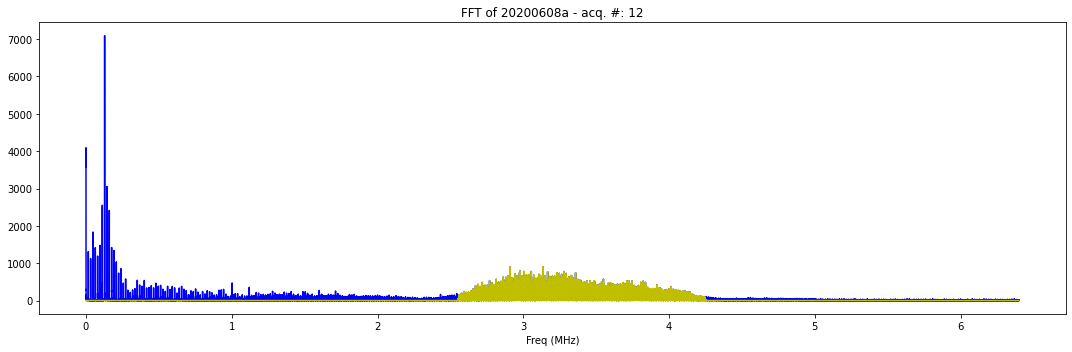

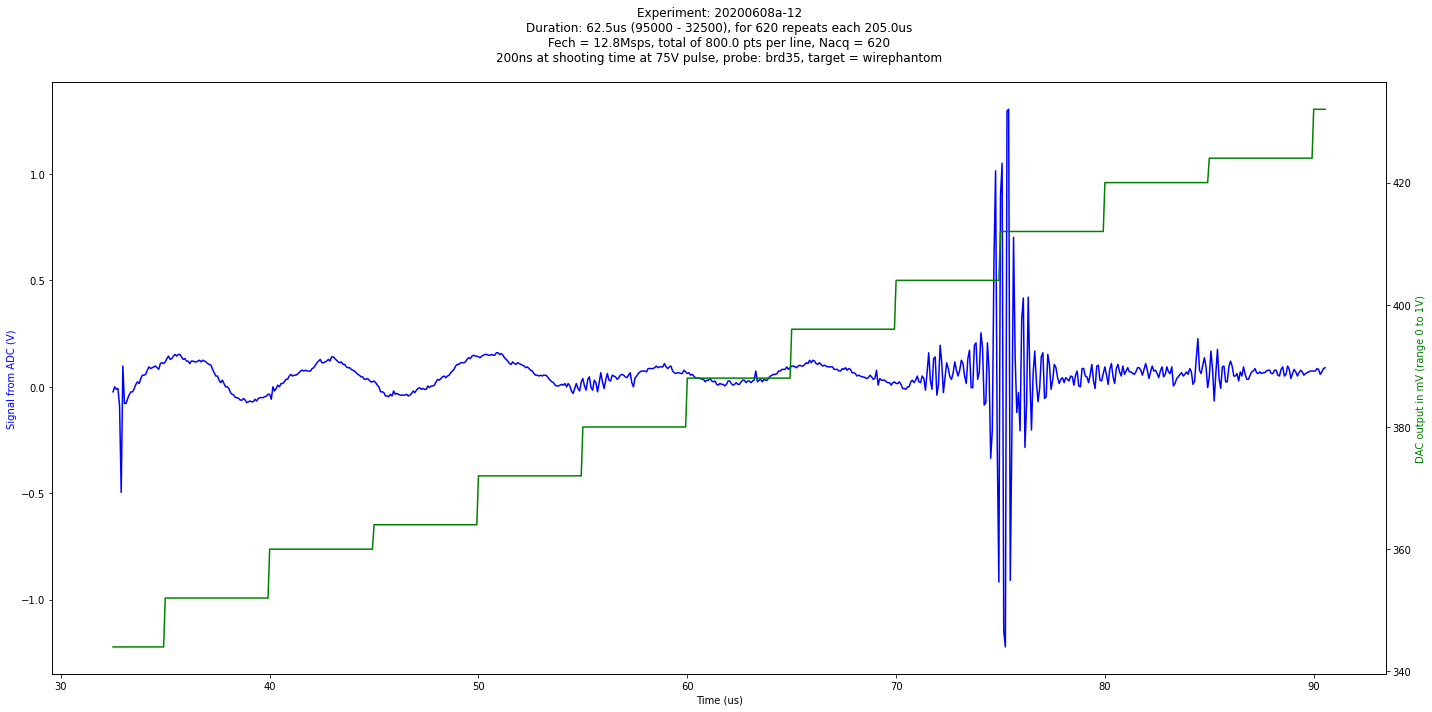

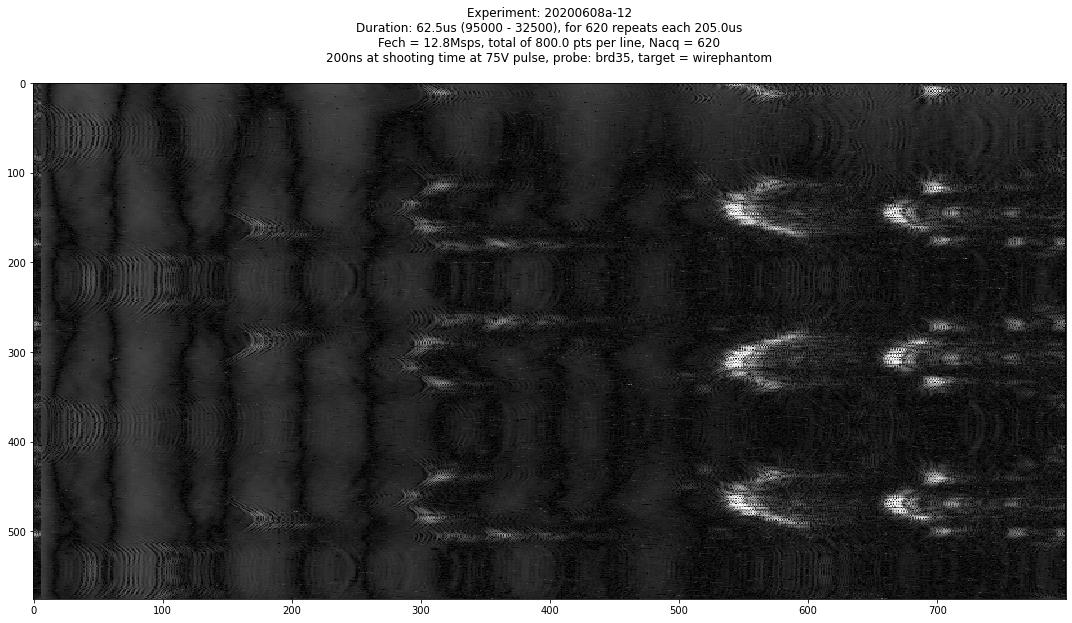

In [2]:
MyDataFile = "20200608a-12.json"

if MyDataFile.endswith(".json"):
    print(MyDataFile)
    y = us.us_json()
    y.show_images = False
    y.JSONprocessing("./data/"+MyDataFile)
    y.fPiezo = 3.4
    y.Bandwidth = 0.5
    y.create_fft() 
    y.save_npz() 
    y.mkImg()
if y.Nacq > 1:
    y.mk2DArray()

800 576
PyExiv not present


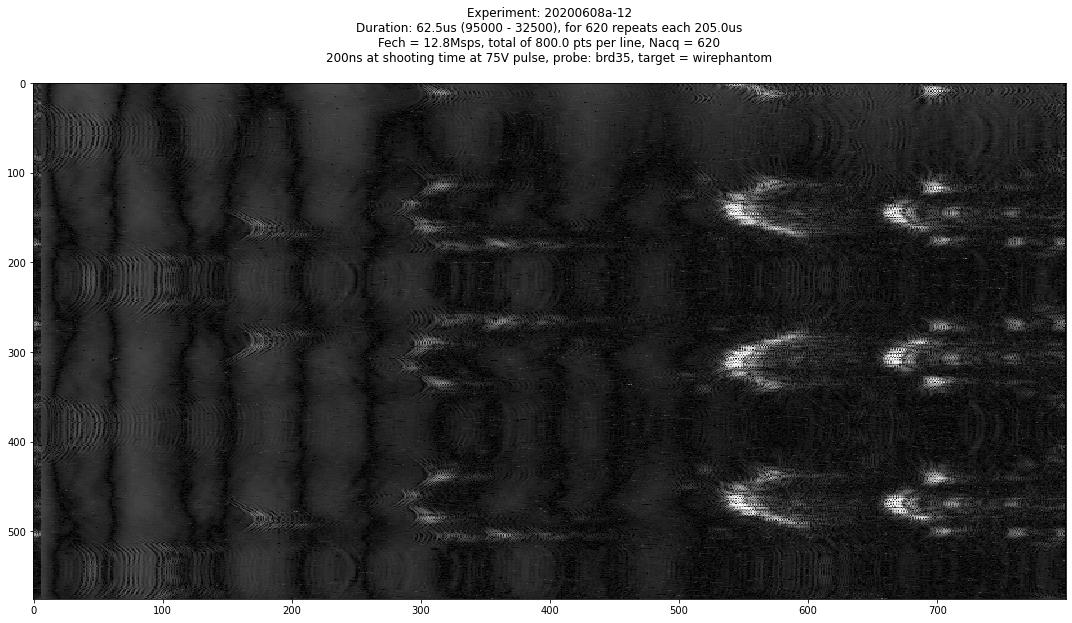

In [3]:
raw_image = y.mk2DArray()
clean_image, fft_image_filtered = y.mkFiltered(raw_image)

In [4]:
img_size =np.shape(clean_image)

hb = np.empty(shape=img_size,dtype='float')
ph = np.empty(shape=img_size,dtype='float')

for k in range(len(hb)):
    sig = hilbert(clean_image[k])
    enveloppe = np.abs(sig)
    phase = np.unwrap(np.angle(sig))
    hb[k] = enveloppe
    ph[k] = phase

In [5]:
np.shape(ph)

(576, 800)

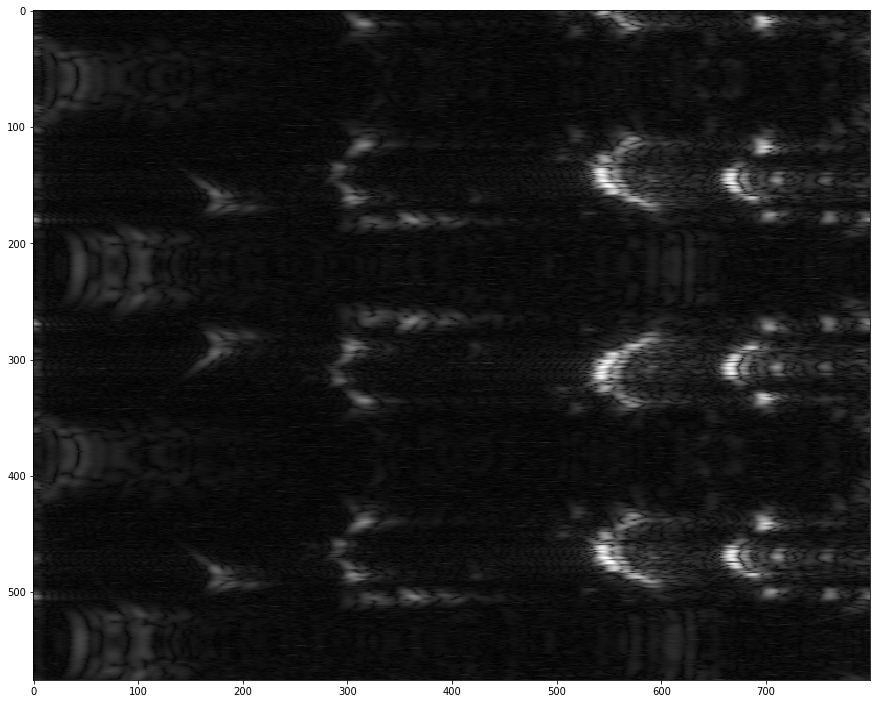

In [6]:
plt.figure(figsize=(15, 15))
plt.imshow(np.sqrt(np.abs(hb)), cmap='gray', aspect=0.8*(img_size[1]/img_size[0]), interpolation='nearest')
plt.show()

163.0
61.0 224.0 387.0 550.0


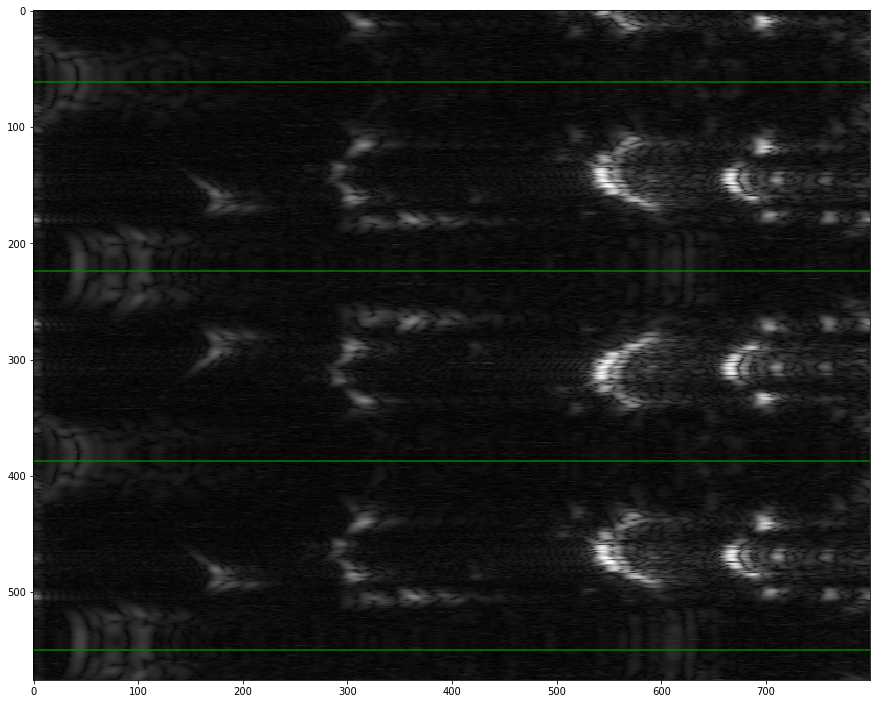

In [7]:
img_size =np.shape(hb)
plt.figure(figsize=(15, 15))
plt.imshow(np.sqrt(np.abs(hb)), cmap='gray', aspect=0.8*(img_size[1]/img_size[0]), interpolation='nearest')
#plt.axhline(y=182,color="red")
plt.axhline(y=(182+266)/2,color="green")
#plt.axhline(y=266,color="red")
#plt.axhline(y=341,color="red")
#plt.axhline(y=433,color="red")
plt.axhline(y=(342+433)/2,color="green")
length = (341+433)/2 - (182+266)/2
print(length)
plt.axhline(y=(182+266)/2 - length,color="green")
plt.axhline(y=(341+433)/2 + length,color="green")
print((182+266)/2 - length,(182+266)/2,(341+433)/2,(341+433)/2 + length)
plt.show()

In [8]:
tInterline = y.parameters['PeriodAcq_Real']/1000.0 # in us
fImage = 1 / (length * tInterline / 1E6)
print(fImage,"images per second.")
print("Close enough to", " (32*60/4/)16 = ",32*60/4/16, " - that's 1/16 of the control freq")

29.92667963489451 images per second.
Close enough to  (32*60/4/)16 =  30.0  - that's 1/16 of the control freq


In [9]:
A = np.abs(hb[61:224])
B = np.abs(np.flipud(hb[224:387]))
C = np.abs(clean_image[387:550])
tmp = np.add(A,B,C)

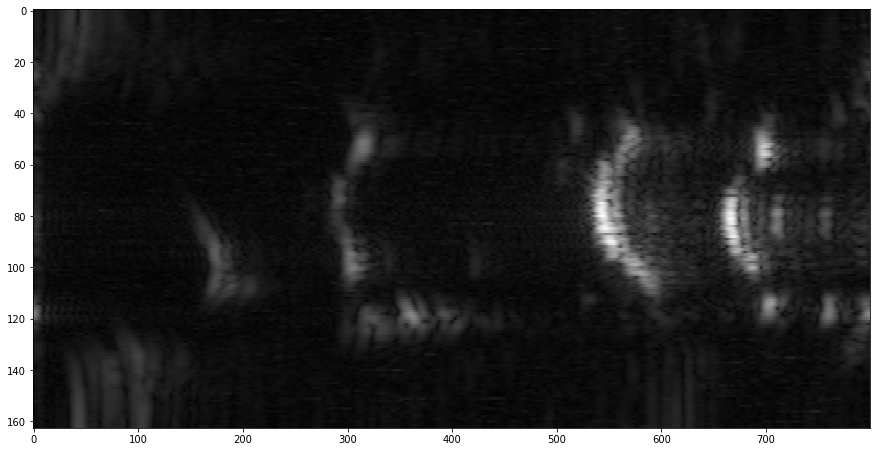

In [10]:
img_size =np.shape(B)
plt.figure(figsize=(15, 15))
plt.imshow(np.sqrt(np.abs(tmp)), cmap='gray', aspect=0.5*(img_size[1]/img_size[0]), interpolation='nearest')


In [11]:
img_size =np.shape(B)
OffSet = int(32.5*64/5.0)
print("OffSet of : ",OffSet," pixels.")
a = np.asarray(B)
b = np.zeros((img_size[0],OffSet)) #70 for the piezo offset


c = np.c_[b,a]
AngleFactor = 1.4
b = np.zeros((int(AngleFactor*img_size[0]),img_size[1]+OffSet)) #70 for the piezo offset
d = np.zeros((int(AngleFactor*img_size[0]),img_size[1]+OffSet)) #70 for the piezo offset
print("Angle of the probe: ",360/(1+2*AngleFactor))
c = np.concatenate([d,c,b])


OffSet of :  416  pixels.
Angle of the probe:  94.73684210526316


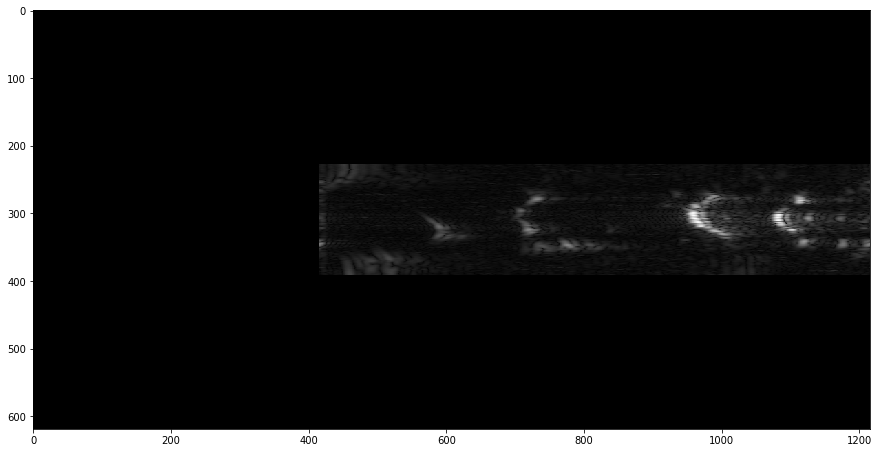

In [12]:
img_size =np.shape(c)
plt.figure(figsize=(15, 15))
plt.imshow(np.sqrt(np.abs(c)), cmap='gray', aspect=0.5*(img_size[1]/img_size[0]), interpolation='nearest')


# Scan conversion

OffSet of :  416  pixels.
Angle of the probe:  94.73684210526316
OffSet of :  416  pixels.
Angle of the probe:  94.73684210526316
OffSet of :  416  pixels.
Angle of the probe:  94.73684210526316


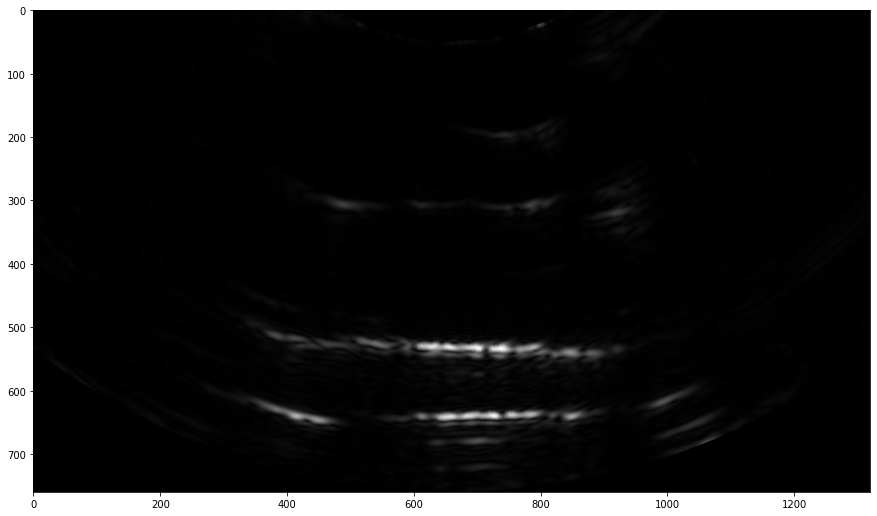

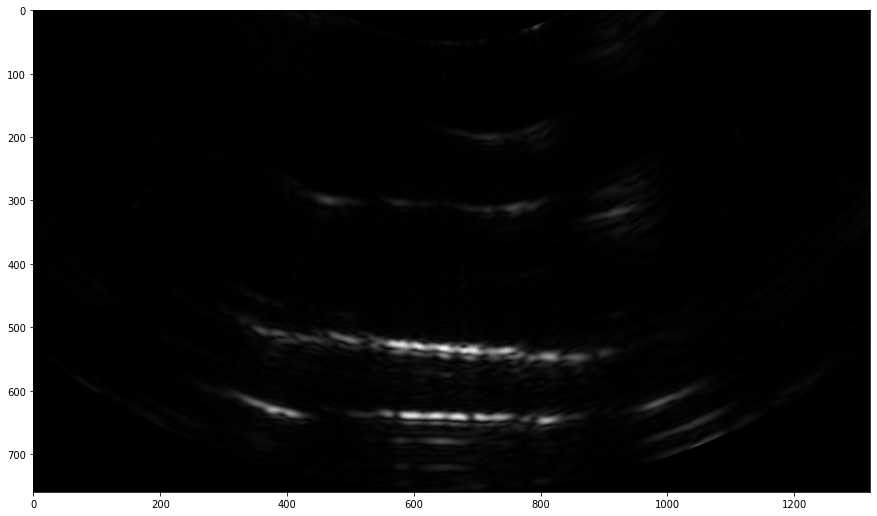

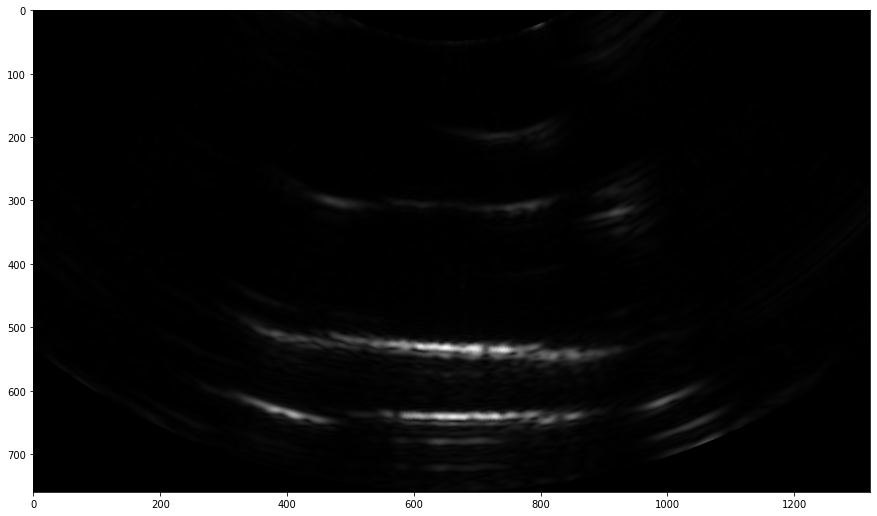

In [13]:
i = 0
filenames = []
for img in [A,B,C]:
    i = i+1
    img_size =np.shape(img)
    OffSet = int(32.5*64/5.0)
    print("OffSet of : ",OffSet," pixels.")
    a = np.asarray(img)
    b = np.zeros((img_size[0],OffSet)) #70 for the piezo offset


    c = np.c_[b,a]
    AngleFactor = 1.4
    b = np.zeros((int(AngleFactor*img_size[0]),img_size[1]+OffSet)) #70 for the piezo offset
    d = np.zeros((int(AngleFactor*img_size[0]),img_size[1]+OffSet)) #70 for the piezo offset
    print("Angle of the probe: ",360/(1+2*AngleFactor))
    c = np.concatenate([d,c,b])

    factor = 2*3*360 / np.shape(c)[0] 
    ResizedFront = ndimage.zoom(np.fliplr(c), (1*factor, factor*np.shape(c)[0]/np.shape(c)[1]))
    #plt.imshow(np.abs(ResizedFront))

    Front_Image = cv2.linearPolar(np.flip(ResizedFront), (2*3*180, 2*3*180), 2*3*180, cv2.WARP_INVERSE_MAP | cv2.WARP_FILL_OUTLIERS)
    plt.figure(figsize=(15, 15))
    RES = np.rot90(np.abs(Front_Image))[2*700:,2*210:2*870]
    plt.imshow(RES, cmap='gray')
    fn = "images/gif_"+str(i)+".jpg"
    filenames.append(fn)
    plt.savefig(fn)

In [17]:
import imageio
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('images/movie.gif', images, format='GIF', duration=0.5)

# Full image

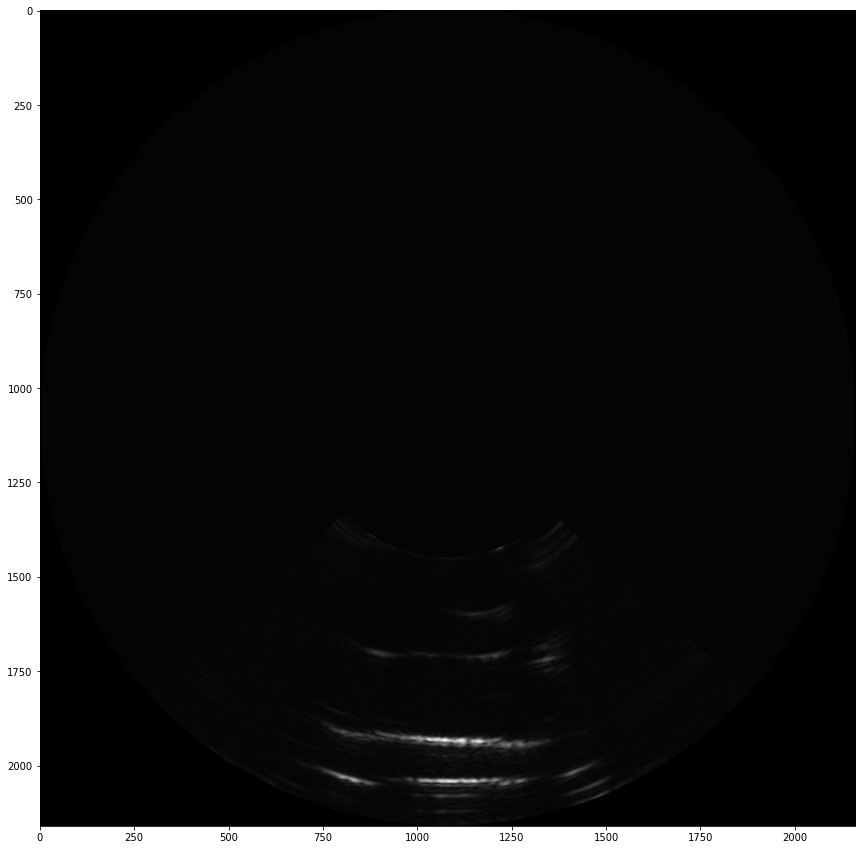

In [16]:
Front_Image = cv2.linearPolar(np.flip(ResizedFront+0.1), (2*3*180, 2*3*180), 2*3*180, cv2.WARP_INVERSE_MAP | cv2.WARP_FILL_OUTLIERS)
plt.figure(figsize=(15, 15))
RES = np.rot90(np.abs(Front_Image))
plt.imshow(RES, cmap='gray')